In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import torch
import random
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import EEGModels 
from EEG_transformer_code.method_A.model import EEGT
import EEG_transformer_code.method_A.params_full_c as params
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
warnings.filterwarnings('ignore')

2023-12-13 08:41:03.039318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 08:41:03.039353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 08:41:03.040371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 08:41:03.046984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 08:41:04.264406: W tensorflow/compiler/tf2

Num GPUs Available:  3


# Configurations

In [2]:
data_path = './dataset'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
cross = 20

cuda:1


# SVM

Begin to process person huangsiye_20210529_1.
Acc of train set: 0.97897
Acc of test set: 0.97745
Begin to process person huangsiye_20210531_2.
Acc of train set: 0.98020
Acc of test set: 0.98244
Begin to process person huangsiye_20210604_3.
Acc of train set: 0.95904
Acc of test set: 0.95636
Begin to process person liangjie_20210424_2.
Acc of train set: 0.84724
Acc of test set: 0.82974
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 0.86805
Acc of test set: 0.87983
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 0.88775
Acc of test set: 0.87950
Begin to process person tana_20210425_1.
Acc of train set: 0.98170
Acc of test set: 0.98083
Begin to process person zengcheng_20210615_1.
Acc of train set: 0.86263
Acc of test set: 0.84844
Begin to process person zengjingyao_20210604_2.
Acc of train set: 0.94146
Acc of test set: 0.92486
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 0.88139
Acc of test set: 0.89721
Begin to process person zhengwen

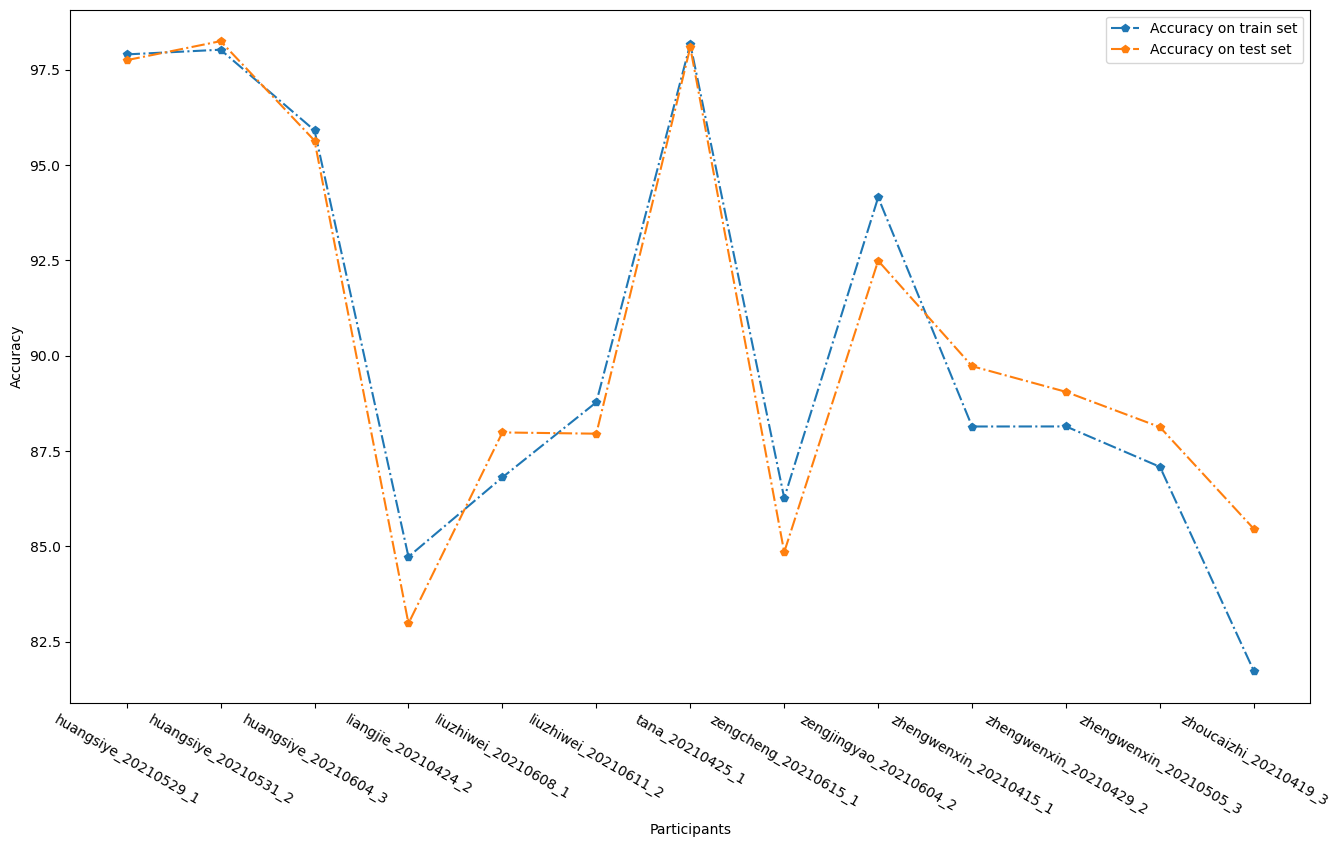

In [3]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_SVM = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = svm.SVC(C=1,kernel='rbf')
        classifier.fit(train_data, train_label)
        trains.append(classifier.score(train_data, train_label))
        tests.append(classifier.score(test_data, test_label))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_SVM.append(acc_test*100)
    acc_trains.append(acc_train*100)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_SVM, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Logistic Regression

Begin to process person huangsiye_20210529_1.
Acc of train set: 0.99610
Acc of test set: 0.97997
Begin to process person huangsiye_20210531_2.
Acc of train set: 0.99353
Acc of test set: 0.98277
Begin to process person huangsiye_20210604_3.
Acc of train set: 0.98092
Acc of test set: 0.95324
Begin to process person liangjie_20210424_2.
Acc of train set: 0.96914
Acc of test set: 0.84349
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 0.97332
Acc of test set: 0.82648
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 0.98062
Acc of test set: 0.86182
Begin to process person tana_20210425_1.
Acc of train set: 0.98818
Acc of test set: 0.97715
Begin to process person zengcheng_20210615_1.
Acc of train set: 0.96537
Acc of test set: 0.84669
Begin to process person zengjingyao_20210604_2.
Acc of train set: 0.98284
Acc of test set: 0.92177
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 0.98076
Acc of test set: 0.85923
Begin to process person zhengwen

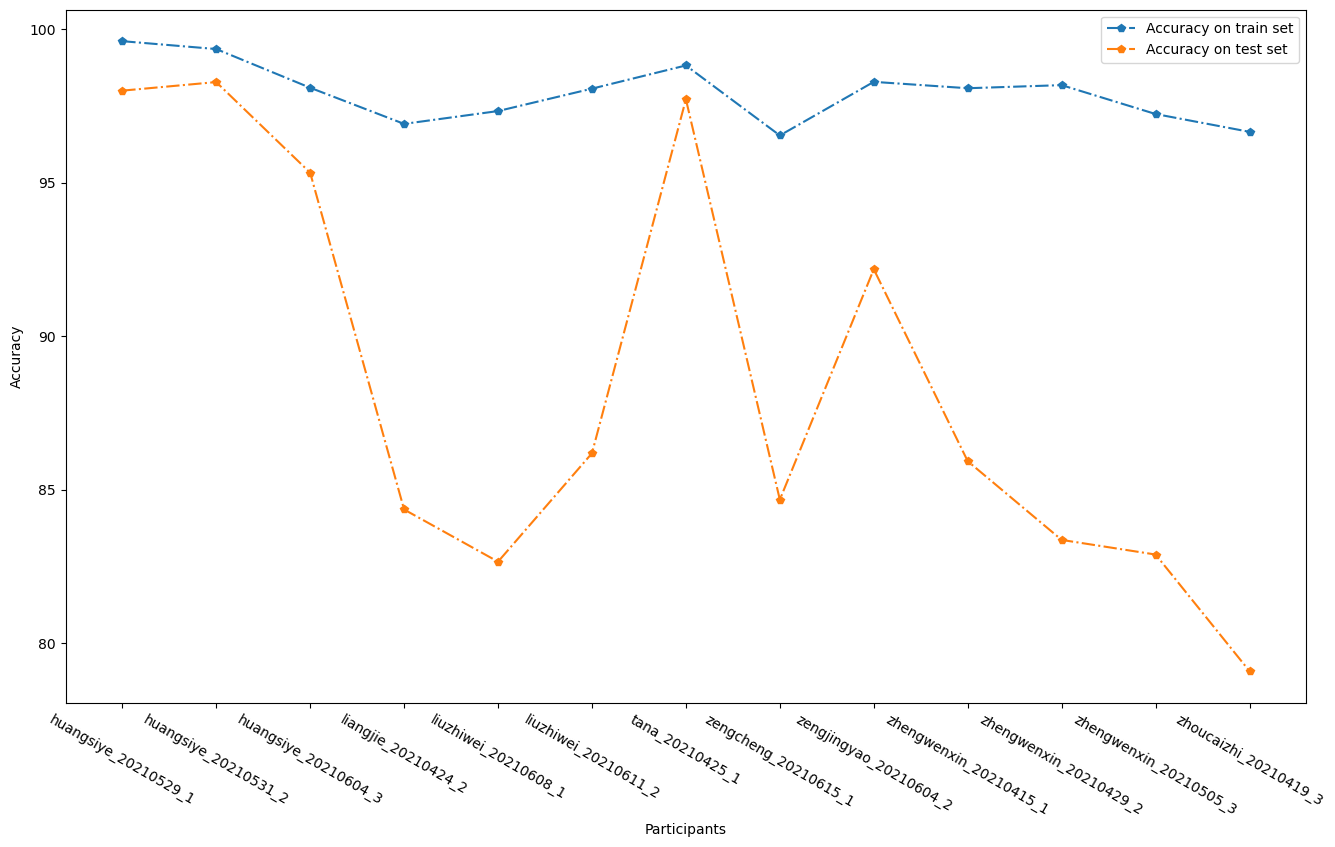

In [4]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_LR = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = LogisticRegression(penalty="l1", C=0.5, solver="liblinear")
        classifier.fit(train_data, train_label)
        trains.append(classifier.score(train_data, train_label))
        tests.append(classifier.score(test_data, test_label))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_LR.append(acc_test*100)
    acc_trains.append(acc_train*100)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_LR, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Decision Tree

Begin to process person huangsiye_20210529_1.
Acc of train set: 1.00000
Acc of test set: 0.96515
Begin to process person huangsiye_20210531_2.
Acc of train set: 1.00000
Acc of test set: 0.96554
Begin to process person huangsiye_20210604_3.
Acc of train set: 1.00000
Acc of test set: 0.92355
Begin to process person liangjie_20210424_2.
Acc of train set: 1.00000
Acc of test set: 0.75760
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 1.00000
Acc of test set: 0.79097
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 1.00000
Acc of test set: 0.80764
Begin to process person tana_20210425_1.
Acc of train set: 1.00000
Acc of test set: 0.95831
Begin to process person zengcheng_20210615_1.
Acc of train set: 1.00000
Acc of test set: 0.80927
Begin to process person zengjingyao_20210604_2.
Acc of train set: 1.00000
Acc of test set: 0.89560
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 1.00000
Acc of test set: 0.81506
Begin to process person zhengwen

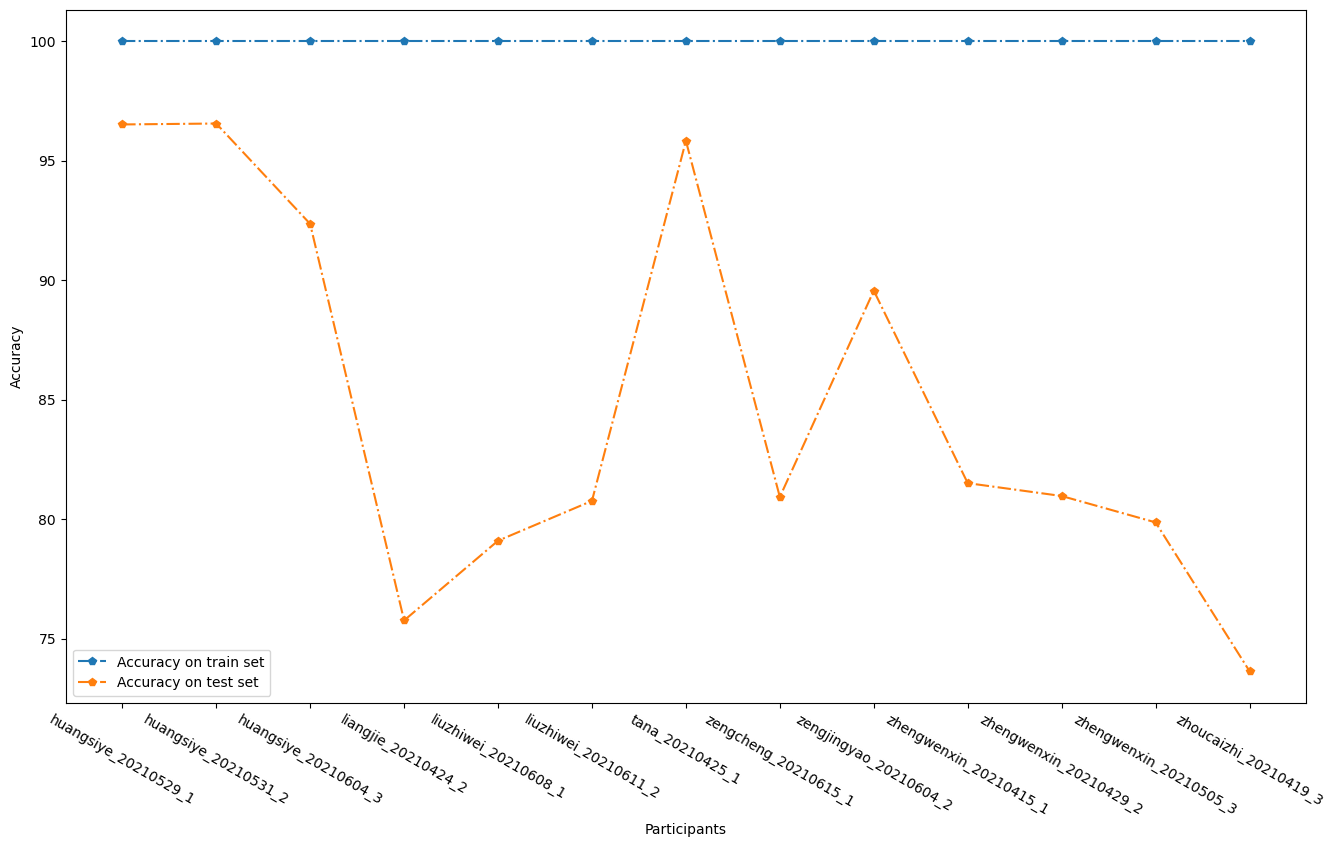

In [5]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_DTC = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = DecisionTreeClassifier(criterion = 'entropy')
        classifier.fit(train_data, train_label)
        trains.append(classifier.score(train_data, train_label))
        tests.append(classifier.score(test_data, test_label))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_DTC.append(acc_test*100)
    acc_trains.append(acc_train*100)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_DTC, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Multi-layer Perceptron

In [6]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(310, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [7]:
def Validation(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100

Begin to process person huangsiye_20210529_1.
Acc of train set: 97.85409
Acc of test set: 97.85625
Begin to process person huangsiye_20210531_2.
Acc of train set: 98.20228
Acc of test set: 97.94853
Begin to process person huangsiye_20210604_3.
Acc of train set: 95.81240
Acc of test set: 95.79801
Begin to process person liangjie_20210424_2.
Acc of train set: 83.93308
Acc of test set: 84.78402
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 86.92502
Acc of test set: 88.64231
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 89.35543
Acc of test set: 86.39545
Begin to process person tana_20210425_1.
Acc of train set: 98.00251
Acc of test set: 98.54126
Begin to process person zengcheng_20210615_1.
Acc of train set: 85.13611
Acc of test set: 85.97978
Begin to process person zengjingyao_20210604_2.
Acc of train set: 92.87173
Acc of test set: 94.79065
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 88.59120
Acc of test set: 88.84570
Begin to pro

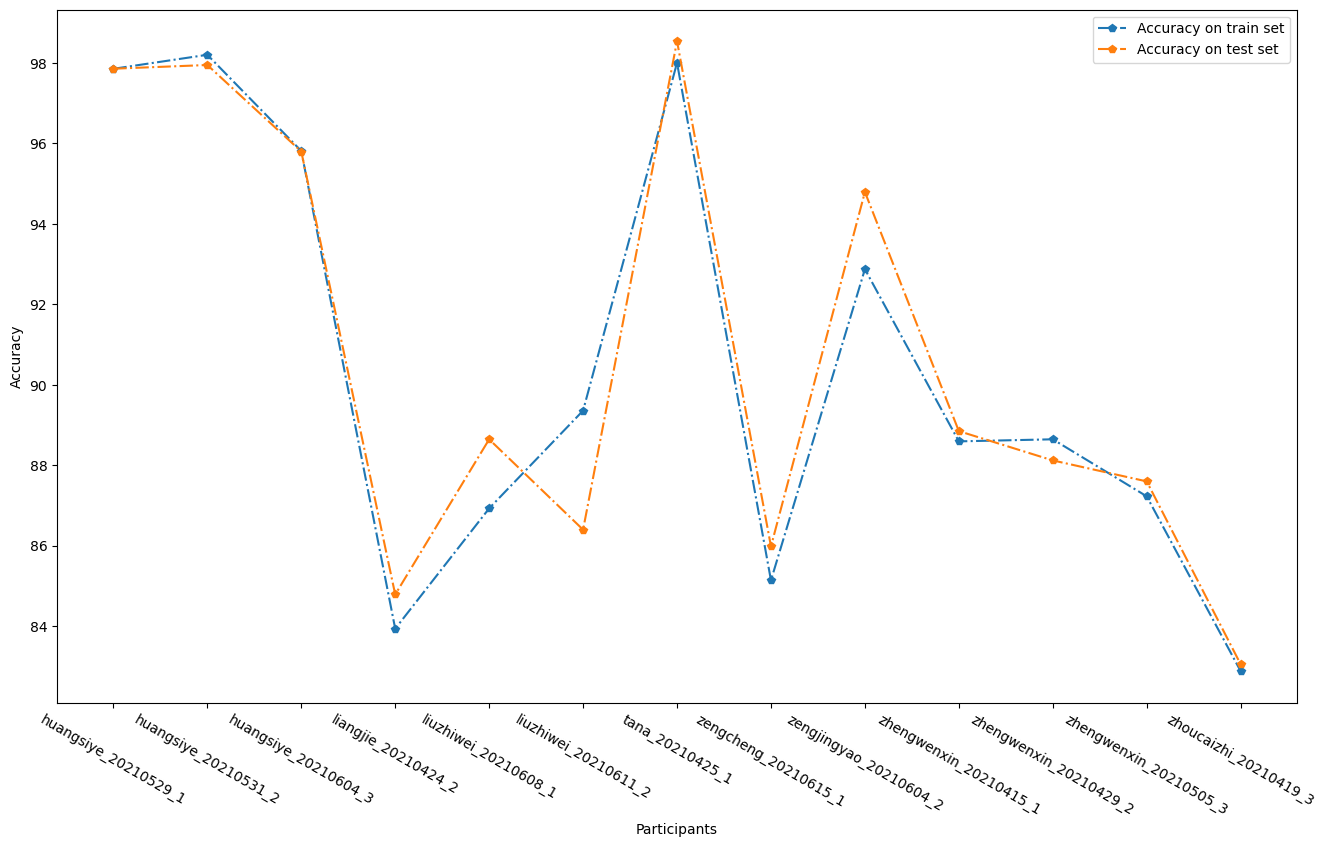

In [8]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_MLP = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        trains.append(Validation(net=net, testloader=train_loader))
        tests.append(Validation(net=net, testloader=test_loader))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_MLP.append(acc_test)
    acc_trains.append(acc_train)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_MLP, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Convolution Neural Network

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN, self).__init__()
        # self.feature_extraction = nn.Sequential(
        #     nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 16, padding = 1),
        #     nn.MaxPool1d(kernel_size = 8, stride = 1),
        #     nn.ReLU(),
        #     nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 16),
        #     nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 16, padding = 1),
        #     nn.ReLU()
        # )  
        # self.classifier = nn.Sequential(
        #     nn.Linear(1048, 2048),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(2048, num_classes)
        # )
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = 4, padding = 1),
            nn.MaxPool1d(kernel_size = 4, stride = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.ReLU()
        )  
        self.classifier = nn.Sequential(
            nn.Linear(1728, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Begin to process person huangsiye_20210529_1.
Acc of train set: 97.90992
Acc of test set: 97.70390
Begin to process person huangsiye_20210531_2.
Acc of train set: 98.23824
Acc of test set: 97.78832
Begin to process person huangsiye_20210604_3.
Acc of train set: 95.75703
Acc of test set: 95.99838
Begin to process person liangjie_20210424_2.
Acc of train set: 84.78968
Acc of test set: 82.48017
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 87.88210
Acc of test set: 85.48015
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 88.87656
Acc of test set: 87.64163
Begin to process person tana_20210425_1.
Acc of train set: 98.20041
Acc of test set: 98.09541
Begin to process person zengcheng_20210615_1.
Acc of train set: 85.72139
Acc of test set: 85.12756
Begin to process person zengjingyao_20210604_2.
Acc of train set: 92.73397
Acc of test set: 94.53280
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 88.50172
Acc of test set: 88.86783
Begin to pro

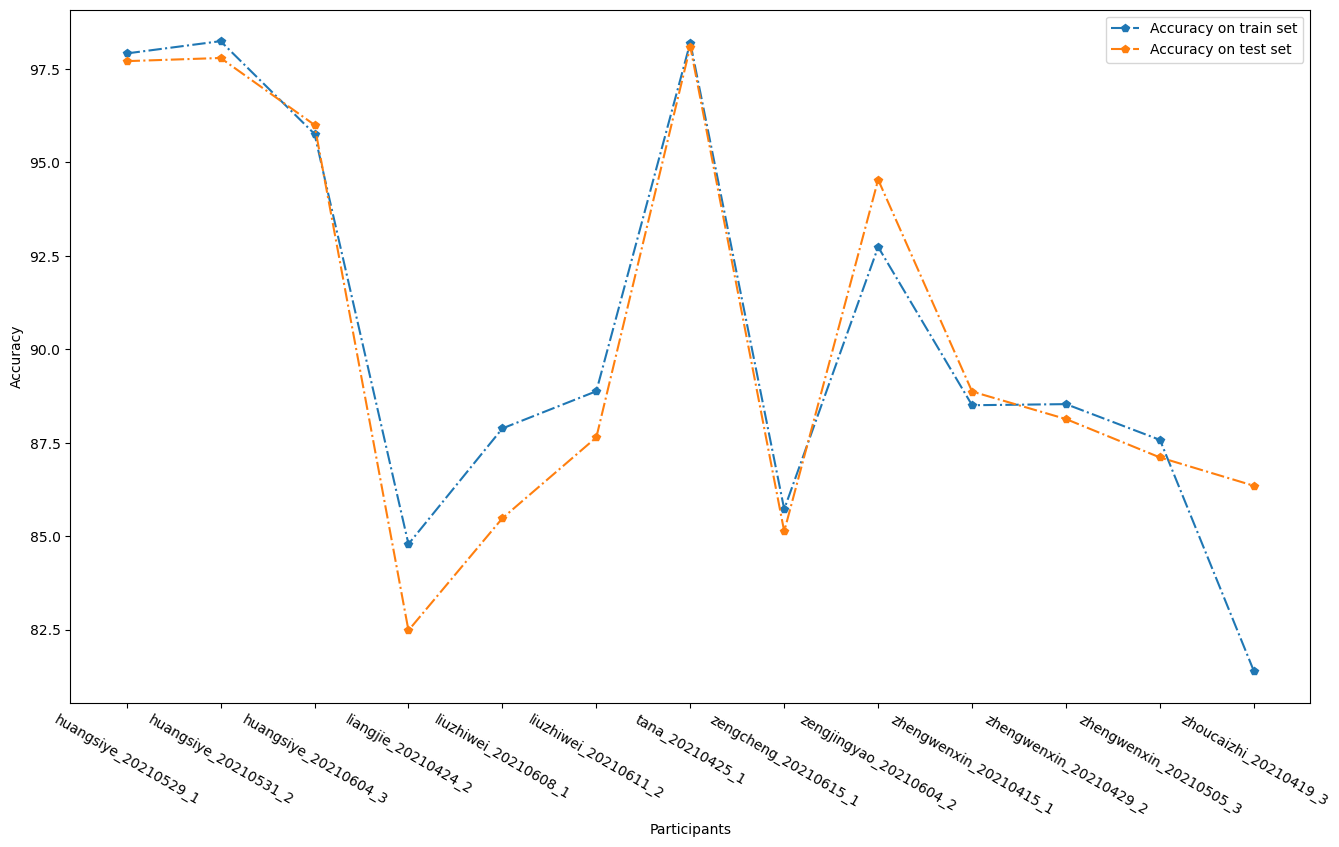

In [10]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_CNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5).permute(0, 2, 1)
        test_data = test_data.reshape(test_data.shape[0], 62, 5).permute(0, 2, 1)
        # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1).permute(0, 2, 1)
        # test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1).permute(0, 2, 1)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        trains.append(Validation(net=net, testloader=train_loader))
        tests.append(Validation(net=net, testloader=test_loader))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_CNN.append(acc_test)
    acc_trains.append(acc_train)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_CNN, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Recurrent Neural Network

In [11]:
class RNN(nn.Module):
    def __init__(self, hidden_size = 32, num_classes = 2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = 5, hidden_size = self.hidden_size, num_layers = 2, batch_first = True, bidirectional = True)
        self.classifier = nn.Sequential(
            nn.Linear(62 * self.hidden_size * 2, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Begin to process person huangsiye_20210529_1.
Acc of train set: 98.21558
Acc of test set: 97.92532
Begin to process person huangsiye_20210531_2.
Acc of train set: 98.22868
Acc of test set: 98.15952
Begin to process person huangsiye_20210604_3.
Acc of train set: 95.90763
Acc of test set: 95.72830
Begin to process person liangjie_20210424_2.
Acc of train set: 85.28119
Acc of test set: 83.94301
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 88.04202
Acc of test set: 86.77897
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 89.67642
Acc of test set: 88.46636
Begin to process person tana_20210425_1.
Acc of train set: 98.30984
Acc of test set: 97.84943
Begin to process person zengcheng_20210615_1.
Acc of train set: 88.84012
Acc of test set: 86.03729
Begin to process person zengjingyao_20210604_2.
Acc of train set: 94.35005
Acc of test set: 93.41641
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 89.84393
Acc of test set: 87.31766
Begin to pro

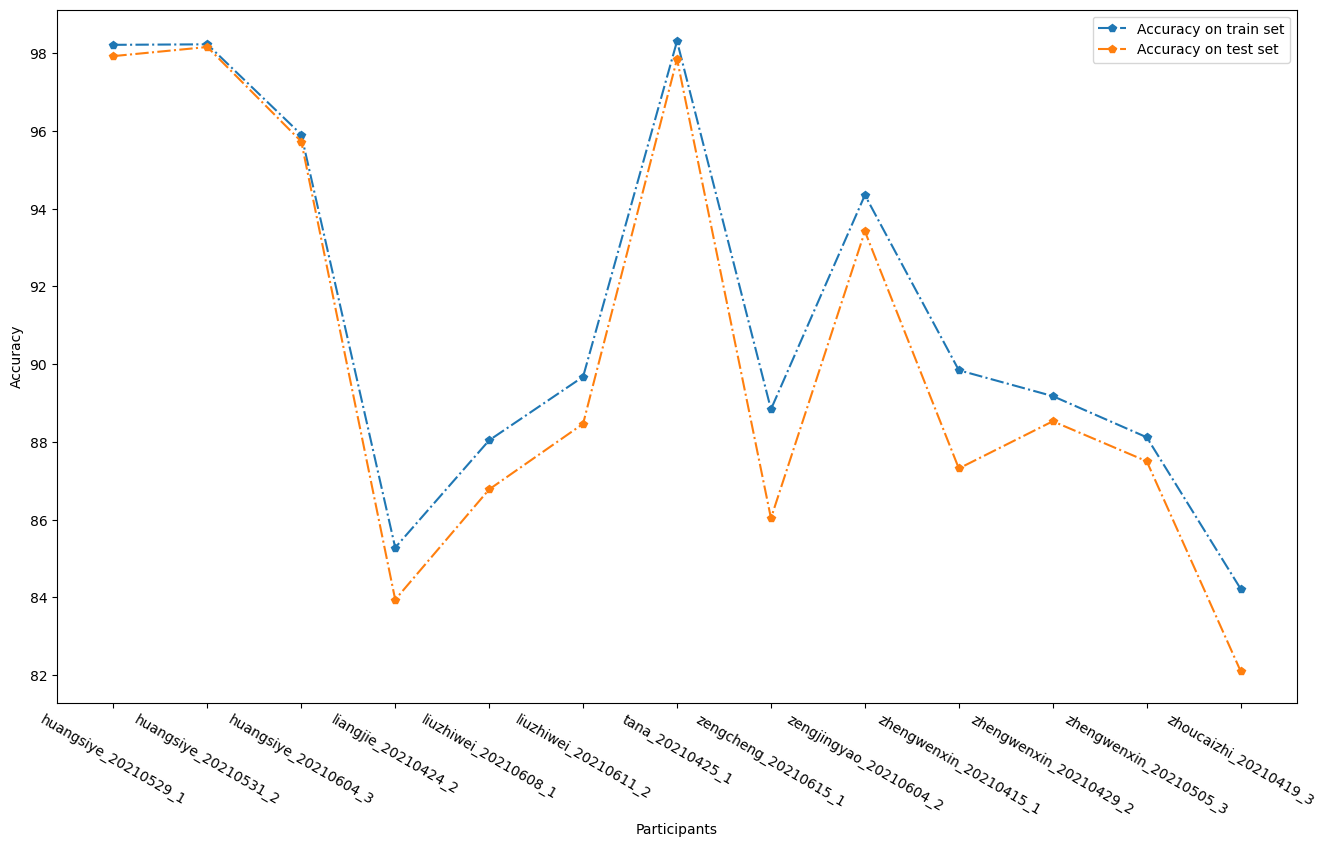

In [12]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_RNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = RNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        trains.append(Validation(net=net, testloader=train_loader))
        tests.append(Validation(net=net, testloader=test_loader))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_RNN.append(acc_test)
    acc_trains.append(acc_train)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_RNN, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# EEGNet

In [ ]:
data_list = os.listdir(data_path)
acc_tests_EEGNet = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = tf.convert_to_tensor(traindata[:,:-1]), tf.convert_to_tensor(traindata[:,-1])
        test_data, test_label = tf.convert_to_tensor(testdata[:,:-1]), tf.convert_to_tensor(testdata[:,-1])
        train_data = tf.reshape(train_data, [train_data.shape[0], 62, 5])
        test_data = tf.reshape(test_data, [test_data.shape[0], 62, 5])
        net = EEGModels.EEGNet_SSVEP(nb_classes=2, Chans=62, Samples=5)
        net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam')
        net.fit(train_data,train_label,batch_size=64,epochs = 15)
        y = net(test_data).numpy()
        y = torch.Tensor(y)
        _, predicted = torch.max(y, 1)
        predicted = predicted.numpy()
        tests.append((predicted==test_label.numpy()).sum().item()/test_label.shape[0])
    acc_test = np.mean(tests)
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_EEGNet.append(acc_test*100)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_tests_EEGNet, '-.p')
plt.legend(['Accuracy on test set'])
plt.show()

In [14]:
def define_model(i):
    return EEGT(
        params.ENC_INPUT_LEN,
        params.CLASSES,
        params.ENC_INPUT_DIM,
        params.ENC_DEPTH[i],
        params.ENC_HEADS,
        params.ENC_MLP_DIM[i],
        params.ENC_POOL,
        params.ENC_DIM_HEAD[i],
        params.ENC_DROPOUT,
        params.ENC_EMB_DROPOUT,
    )

Begin to process person huangsiye_20210529_1.
Acc of train set: 97.83779
Acc of test set: 97.93865
Begin to process person huangsiye_20210531_2.
Acc of train set: 98.37993
Acc of test set: 97.49554
Begin to process person huangsiye_20210604_3.
Acc of train set: 95.78759
Acc of test set: 95.81975
Begin to process person liangjie_20210424_2.
Acc of train set: 84.09524
Acc of test set: 84.79298
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 86.58371
Acc of test set: 88.79066
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 88.97790
Acc of test set: 87.56928
Begin to process person tana_20210425_1.
Acc of train set: 98.07754
Acc of test set: 98.37982
Begin to process person zengcheng_20210615_1.
Acc of train set: 85.52941
Acc of test set: 85.36564
Begin to process person zengjingyao_20210604_2.
Acc of train set: 93.70027
Acc of test set: 92.69658
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 88.59733
Acc of test set: 88.98756
Begin to pro

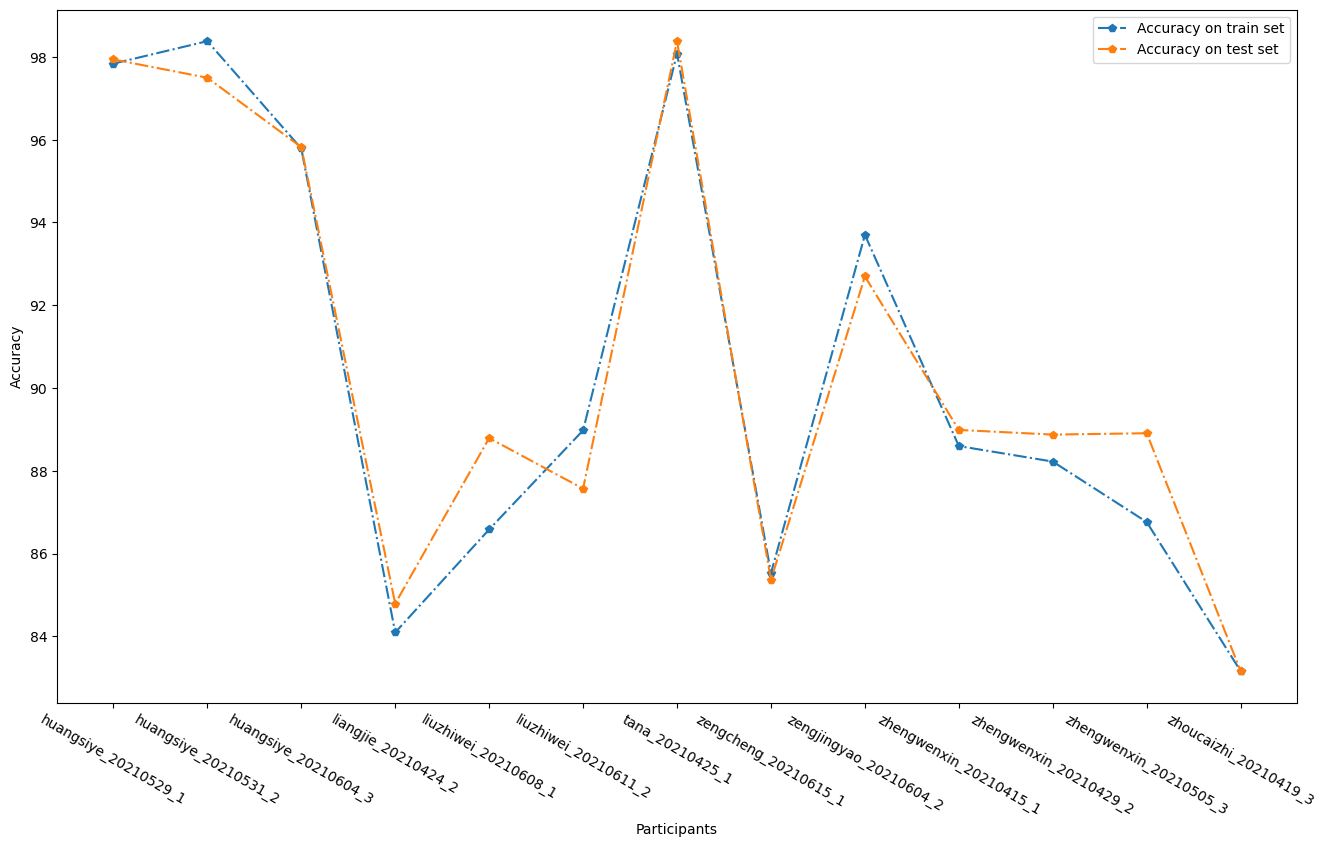

In [15]:
data_list = os.listdir(data_path)
acc_trains = []
acc_tests_Transformer = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = define_model(0).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                net.train()
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        trains.append(Validation(net=net, testloader=train_loader))
        tests.append(Validation(net=net, testloader=test_loader))
    acc_train, acc_test = np.mean(trains), np.mean(tests)
    print("Acc of train set: {:.5f}".format(acc_train))
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_Transformer.append(acc_test)
    acc_trains.append(acc_train)
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
x = os.listdir(data_path)
plt.plot(x, acc_trains, '-.p')
plt.plot(x, acc_tests_Transformer, '-.p')
plt.legend(['Accuracy on train set','Accuracy on test set'])
plt.show()

# Comparison of different models

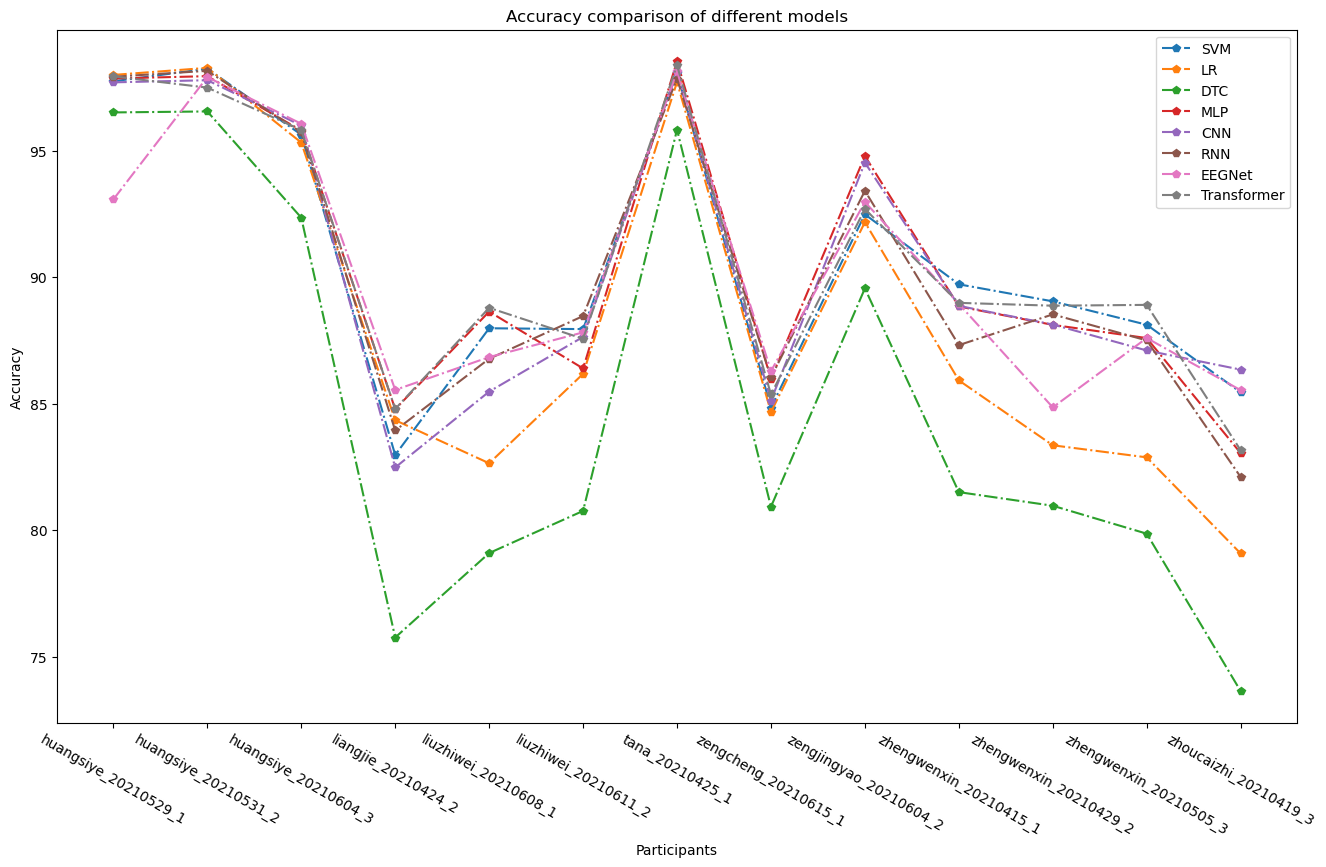

In [16]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
plt.title("Accuracy comparison of different models")
x = os.listdir(data_path)
plt.plot(x, acc_tests_SVM, '-.p')
plt.plot(x, acc_tests_LR, '-.p')
plt.plot(x, acc_tests_DTC, '-.p')
plt.plot(x, acc_tests_MLP, '-.p')
plt.plot(x, acc_tests_CNN, '-.p')
plt.plot(x, acc_tests_RNN, '-.p')
plt.plot(x, acc_tests_EEGNet, '-.p')
plt.plot(x, acc_tests_Transformer, '-.p')
plt.legend(['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer'])
plt.show()

[90.63758217672671, 88.50618799458763, 84.87224716405181, 90.64184848977617, 90.40776420986842, 90.28916785080142, 90.12292763542017, 90.67535516910132]
[5.078964936192753, 6.538081301618687, 7.828670510799129, 5.307813765468653, 5.35421298762981, 5.3885236896432955, 4.684532983288078, 5.0449475221209745]


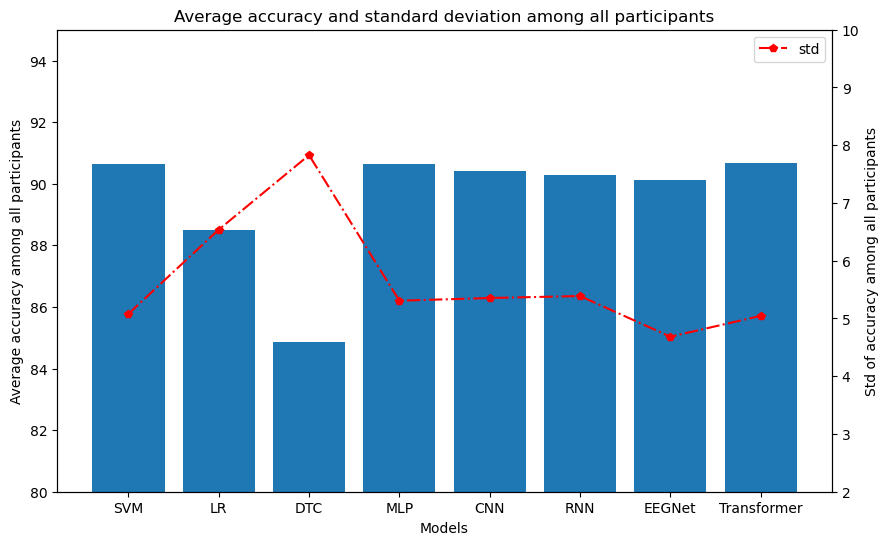

In [18]:
average = [np.mean(acc_tests_SVM), np.mean(acc_tests_LR), np.mean(acc_tests_DTC), 
           np.mean(acc_tests_MLP), np.mean(acc_tests_CNN), np.mean(acc_tests_RNN), np.mean(acc_tests_EEGNet), np.mean(acc_tests_Transformer)]
std = [np.std(acc_tests_SVM), np.std(acc_tests_LR), np.std(acc_tests_DTC), 
       np.std(acc_tests_MLP), np.std(acc_tests_CNN), np.std(acc_tests_RNN), np.std(acc_tests_EEGNet), np.std(acc_tests_Transformer)]
models = ['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average accuracy among all participants')
ax1.set_ybound(80, 95)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of accuracy among all participants')
ax2.set_ybound(2.0, 10.0)
plt.title("Average accuracy and standard deviation among all participants")
plt.legend(['std'])
fig.show()